# Import Required Libraries
Import the necessary libraries, including Open3D.

In [16]:
import open3d as o3d  # Import Open3D library for point cloud processing
import numpy as np  # Import NumPy for numerical operations

# Read Point Cloud Data
Read the point cloud data from a file using Open3D.

In [73]:
import open3d as o3d
import numpy as np

# 读取点云
pcd = o3d.io.read_point_cloud("thickboard.pcd")

# 分割第一个平面
plane_model_1, inliers_1 = pcd.segment_plane(distance_threshold=0.5, ransac_n=3, num_iterations=1000)
inlier_cloud_1 = pcd.select_by_index(inliers_1)
outlier_cloud_1 = pcd.select_by_index(inliers_1, invert=True)

# 分割第二个平面
plane_model_2, inliers_2 = outlier_cloud_1.segment_plane(distance_threshold=0.5, ransac_n=3, num_iterations=1000)
inlier_cloud_2 = outlier_cloud_1.select_by_index(inliers_2)
outlier_cloud_2 = outlier_cloud_1.select_by_index(inliers_2, invert=True)

# 获取平面法向量
normal_1 = np.array(plane_model_1[:3])
normal_2 = np.array(plane_model_2[:3])

# 归一化法向量
normal_1 = normal_1 / np.linalg.norm(normal_1)
normal_2 = normal_2 / np.linalg.norm(normal_2)

# 计算坐标系的旋转矩阵
# 使用第一个平面的法向量作为z轴
z_axis = - normal_1
y_axis = normal_2
# 计算x轴（使用叉积）
x_axis = np.cross(normal_1, normal_2)
x_axis = x_axis / np.linalg.norm(x_axis)

# 打印平面法向量
print("平面1法向量:", x_axis)
print("平面2法向量:", y_axis)

# 构建旋转矩阵
rotation_matrix = np.vstack((x_axis, y_axis, z_axis)).T
print("旋转矩阵:", rotation_matrix)
# 计算逆矩阵
inverse_rotation_matrix = np.linalg.inv(rotation_matrix)
# print("逆矩阵:", inverse_rotation_matrix)

# 找到最高点作为坐标系原点
points = np.asarray(pcd.points)
max_z_point = points[np.argmax(points[:, 2])]
print("坐标系原点:", max_z_point)

# 创建坐标系
frames = []
camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50)
frames.append(camera_frame)
workpiece_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50, origin=max_z_point)
workpiece_frame.rotate(rotation_matrix, center=max_z_point)
frames.append(workpiece_frame)


# 可视化
o3d.visualization.draw_geometries([inlier_cloud_1, outlier_cloud_1] + [frames[0]])
# o3d.visualization.draw_geometries([pcd] + frames)
# o3d.visualization.draw_geometries([pcd, camera_frame])


平面1法向量: [ 0.04631076  0.99889679 -0.00777918]
平面2法向量: [ 0.93099953 -0.04033763  0.36278473]
旋转矩阵: [[ 0.04631076  0.93099953  0.38448946]
 [ 0.99889679 -0.04033763 -0.02501215]
 [-0.00777918  0.36278473 -0.92279047]]
坐标系原点: [  3.71207905   0.55968571 537.33026123]


In [23]:
# 将点云数据从camera_frame转换到workpiece_frame
def transform_point_cloud(pcd, rotation_matrix, translation_vector):
    """
    将点云数据从一个坐标系转换到另一个坐标系
    
    参数:
    pcd: Open3D点云对象
    rotation_matrix: 旋转矩阵
    translation_vector: 平移向量
    """
    # 获取点云中的点
    points = np.asarray(pcd.points)
    
    # 应用旋转矩阵和平移向量进行坐标变换
    transformed_points = np.dot(points, rotation_matrix) -np.dot(translation_vector, rotation_matrix)
    # points -= translation_vector  
    # transformed_points = np.dot(points, rotation_matrix) 
    
    # 创建新的点云对象
    transformed_pcd = o3d.geometry.PointCloud()
    transformed_pcd.points = o3d.utility.Vector3dVector(transformed_points)
    
    return transformed_pcd

# 计算平移向量
translation_vector =   max_z_point
# translation_vector = [-3.71207905, -0.55968571, 537.33026123]


# 转换点云数据
transformed_pcd = transform_point_cloud(pcd, rotation_matrix , translation_vector)



# 显示转换后的点云数据
o3d.visualization.draw_geometries([pcd, transformed_pcd, camera_frame])
# o3d.visualization.draw_geometries([pcd, camera_frame])
# o3d.visualization.draw_geometries([pcd, transformed_pcd])
o3d.io.write_point_cloud("workpiece_frame.pcd", transformed_pcd)
print("平面1法向量:", normal_1)
print("平面2法向量:", normal_2)
print(camera_frame)

平面1法向量: [-0.3846126   0.02497159  0.92274025]
平面2法向量: [ 0.9319482  -0.03852072  0.36053947]
TriangleMesh with 1134 points and 2240 triangles.


In [ ]:
weldpos_workpiece= [[0, -1.8253968253968254, 5],[10, -1.8253968253968254, 5]]
weldpos_camera = np.dot(points, rotation_matrix.T) + translation_vector
print(weldpos_camera)

[[3.93543820e+00 5.06622831e-01 5.32056083e+02]
 [4.39293717e+00 1.04958227e+01 5.31974957e+02]]


In [79]:
import numpy as np

def interpolate_weldpos(weldpos_workpiece, num_points):
    """
    插值 weldpos_workpiece 中的 yz 坐标，z 坐标保持不变，x 坐标等间距
    
    参数:
    weldpos_workpiece: 原始焊接位置坐标列表，格式为 [[x1, y1, z1], [x2, y2, z2]]
    num_points: 插值后的总点数
    
    返回:
    interpolated_points: 插值后的焊接位置坐标列表
    """
    # 提取原始坐标
    x_coords = [pos[0] for pos in weldpos_workpiece]
    y_coords = [pos[1] for pos in weldpos_workpiece]
    z_coords = [pos[2] for pos in weldpos_workpiece]
    
    # 生成等间距的 x 坐标
    x_interp = np.linspace(x_coords[0], x_coords[-1], num_points)
    
    # 进行线性插值
    y_interp = np.interp(x_interp, x_coords, y_coords)
    z_interp = np.interp(x_interp, x_coords, z_coords)  # z 坐标保持不变
    
    # 组合插值后的坐标
    interpolated_points = np.column_stack((x_interp, y_interp, z_interp))
    
    return interpolated_points

# 示例调用
weldpos_workpiece = [[0, -1.8253968253968254, 19], [100, -1.8253968253968254, 19]]
num_points = 100  # 插值后的总点数

weldtraj_workpiece = interpolate_weldpos(weldpos_workpiece, num_points)
weldtraj_camera = np.dot(weldtraj_workpiece, rotation_matrix.T) + translation_vector
weldpos_camera = np.dot(weldpos_workpiece, rotation_matrix.T) + translation_vector
weldtraj_camera2 = interpolate_weldpos(weldpos_camera, 50)
print(weldtraj_camera2)

[[9.31793528e+00 1.58087093e-01 5.19135016e+02]
 [9.41244705e+00 2.19665197e+00 5.19119140e+02]
 [9.50695881e+00 4.23521685e+00 5.19103265e+02]
 [9.60147057e+00 6.27378173e+00 5.19087389e+02]
 [9.69598234e+00 8.31234660e+00 5.19071513e+02]
 [9.79049410e+00 1.03509115e+01 5.19055637e+02]
 [9.88500586e+00 1.23894764e+01 5.19039761e+02]
 [9.97951763e+00 1.44280412e+01 5.19023885e+02]
 [1.00740294e+01 1.64666061e+01 5.19008009e+02]
 [1.01685412e+01 1.85051710e+01 5.18992133e+02]
 [1.02630529e+01 2.05437359e+01 5.18976258e+02]
 [1.03575647e+01 2.25823008e+01 5.18960382e+02]
 [1.04520764e+01 2.46208656e+01 5.18944506e+02]
 [1.05465882e+01 2.66594305e+01 5.18928630e+02]
 [1.06411000e+01 2.86979954e+01 5.18912754e+02]
 [1.07356117e+01 3.07365603e+01 5.18896878e+02]
 [1.08301235e+01 3.27751251e+01 5.18881002e+02]
 [1.09246353e+01 3.48136900e+01 5.18865126e+02]
 [1.10191470e+01 3.68522549e+01 5.18849250e+02]
 [1.11136588e+01 3.88908198e+01 5.18833375e+02]
 [1.12081705e+01 4.09293847e+01 5.188174

In [80]:
point_weldpos = o3d.geometry.PointCloud()
point_weldpos.points = o3d.utility.Vector3dVector(weldtraj_camera)
point_weldpos.paint_uniform_color([0, 1, 0])  # 将点设置为绿色

point_weldpos2 = o3d.geometry.PointCloud()
point_weldpos2.points = o3d.utility.Vector3dVector(weldtraj_camera2)
point_weldpos2.paint_uniform_color([0, 0, 1])  # 将点设置为绿色

# 可视化
o3d.visualization.draw_geometries([inlier_cloud_1, outlier_cloud_1, point_weldpos, point_weldpos2] + [frames[0]])
# o3d.visualization.draw_geometries([pcd] + frames)
# o3d.visualization.draw_geometries([pcd, camera_frame])

# Crop Point Cloud
Crop the point cloud data to a specified region of interest.

In [51]:
# Crop Point Cloud
# Define a bounding box for cropping
new_pcd = o3d.io.read_point_cloud("workpiece_frame.pcd")
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(-15, -30, -50), max_bound=(100, 0, 50))

# Crop the point cloud using the bounding box
cropped_pcd = new_pcd.crop(bbox)

# Display the cropped point cloud data

workpiece_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
o3d.visualization.draw_geometries([cropped_pcd] + [workpiece_frame])

# Denoise Point Cloud
Apply denoising techniques to the point cloud data to remove noise.

In [74]:
# Denoise Point Cloud
# Apply statistical outlier removal to denoise the point cloud
cl, ind = cropped_pcd.remove_statistical_outlier(nb_neighbors=5, std_ratio=3.0)

# Select inliers (denoised point cloud)
denoised_pcd = cropped_pcd.select_by_index(ind)
# denoised_pcd = pcd.select_by_index(ind)

# Display the denoised point cloud data
o3d.visualization.draw_geometries([denoised_pcd])

# Slice Point Cloud
Slice the point cloud data into smaller sections.

Points dimensions: (17452, 3)
mask: [False False False ... False False False]
0.06003328785300255 18.75077247619629 -29.790132522583008 -0.03912345692515373


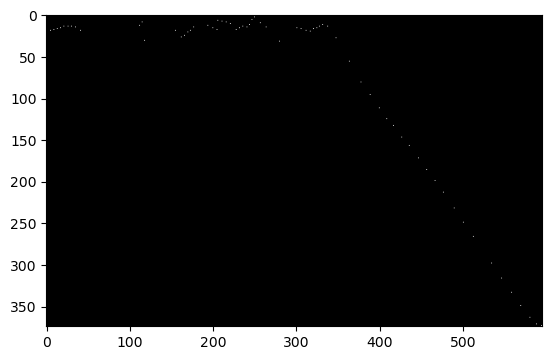

In [72]:
import matplotlib.pyplot as plt
from PIL import Image

def project_to_yz_plane(pcd, gap, resolution=20.0, x_threshold=0.1):
    """
    将点云投影到YZ平面并转换为图片
    
    参数:
    pcd: Open3D点云对象
    resolution: 栅格分辨率（单位：与点云单位相同）
    x_threshold: x方向上的截取范围（距离YZ平面的距离）
    """
    # 转换为numpy数组
    points = np.asarray(pcd.points)
    print("Points dimensions:", points.shape)

    # print(points.size())
    
    # 截取靠近YZ平面的点（x接近0的点）
    # mask = np.abs(points[:, 0]) < x_threshold
    
    mask = (np.abs(points[:, 0]) > gap) & (np.abs(points[:, 0]) < (gap + x_threshold))
    print('mask:', mask)

    yz_points = points[mask][:, 1:]  # 只保留y和z坐标
    
    if len(yz_points) == 0:
        print("没有找到在指定范围内的点！")
        return None
    
    # 计算点云范围
    y_min, z_min = np.min(yz_points, axis=0)
    y_max, z_max = np.max(yz_points, axis=0)

    print(z_min, z_max, y_min, y_max)
    
    # 计算图像尺寸
    height = int((z_max - z_min) / resolution) + 1
    # height = int((18.8) / resolution) + 1
    width = int((y_max - y_min) / resolution) + 1
    
    # 创建空白图像
    image = np.zeros((height, width), dtype=np.uint8)
    
    # 将点投影到图像上
    for point in yz_points:
        y, z = point
        # 计算对应的像素坐标
        pixel_x = int((y - y_min) / resolution)
        pixel_y = int((z - z_min) / resolution)
        # 确保在图像范围内
        if 0 <= pixel_x < width and 0 <= pixel_y < height:
            image[height - 1 - pixel_y, pixel_x] = 255  # 上下翻转以匹配常规坐标系

    return image
gap = 15
img = project_to_yz_plane(denoised_pcd, gap, resolution=0.05, x_threshold=0.5)
# 保存图片
if img is not None:
    img_pil = Image.fromarray(img)
    img_pil.save(f"./images/projected_image_{gap}.png")

plt.imshow(img, cmap='gray')
    

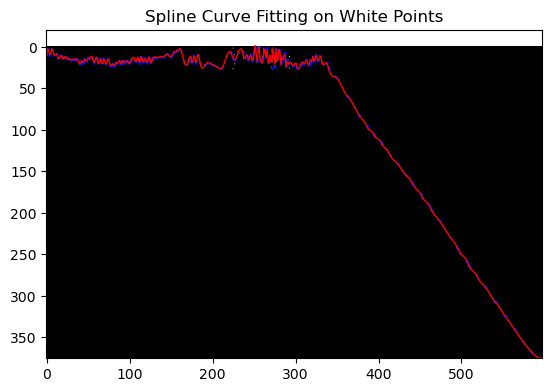

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# 加载图像
image = cv2.imread('projected_image.png', cv2.IMREAD_GRAYSCALE)

# 提取白色点的坐标
points = np.column_stack(np.where(image == 255))

# 按x坐标排序
points = points[points[:, 1].argsort()]

# 对相同x坐标的点取平均值
unique_x = np.unique(points[:, 1])
avg_points = []
for x in unique_x:
    y_values = points[points[:, 1] == x][:, 0]
    avg_y = np.mean(y_values)
    avg_points.append([avg_y, x])

avg_points = np.array(avg_points)

# 拟合样条曲线
x_data = avg_points[:, 1]  # x坐标
y_data = avg_points[:, 0]  # y坐标
spline = UnivariateSpline(x_data, y_data, s=0.1)
# 生成拟合曲线的点
x_fit = np.linspace(x_data.min(), x_data.max(), 500)
y_fit = spline(x_fit)

# 绘制结果
plt.imshow(image, cmap='gray')
plt.plot(x_fit, y_fit, color='red', linewidth=1)
plt.scatter(x_data, y_data, color='blue', s=1)
plt.title('Spline Curve Fitting on White Points')
plt.show()

In [8]:
y_pix = 188 - 10 * z_workpiece
for point in points:
    y, z = point
    if y >= y_pix:
        y = y_pix

NameError: name 'z_workpiece' is not defined

41910


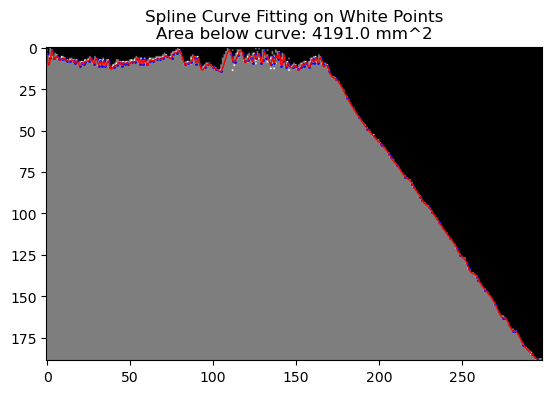

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# 加载图像
image = cv2.imread('projected_image.png', cv2.IMREAD_GRAYSCALE)

# 提取白色点的坐标
points = np.column_stack(np.where(image == 255))

# 按x坐标排序
points = points[points[:, 1].argsort()]

# 对相同x坐标的点取平均值
unique_x = np.unique(points[:, 1])
avg_points = []
for x in unique_x:
    y_values = points[points[:, 1] == x][:, 0]
    avg_y = np.mean(y_values)
    avg_points.append([avg_y, x])

avg_points = np.array(avg_points)

# 拟合样条曲线
x_data = avg_points[:, 1]  # x坐标
y_data = avg_points[:, 0]  # y坐标
spline = UnivariateSpline(x_data, y_data, s=0.1)

# 生成拟合曲线的点
x_fit = np.linspace(x_data.min(), x_data.max(), 500)
y_fit = spline(x_fit)

# 创建掩码图像
mask = np.zeros_like(image, dtype=np.uint8)

# 将拟合曲线以下的区域填充为白色
for i in range(len(x_fit) - 1):
    x1, y1 = int(x_fit[i]), int(y_fit[i])
    x2, y2 = int(x_fit[i + 1]), int(y_fit[i + 1])
    cv2.line(mask, (x1, y1), (x2, y2), 255, 1)

# 填充曲线以下的区域
for x in range(mask.shape[1]):
    y_values = np.where(mask[:, x] == 255)[0]
    if len(y_values) > 0:
        y_min = y_values.min()
        mask[y_min:, x] = 255

# 计算填充区域的面积
area = np.sum(mask == 255)
print(area)

# 绘制结果
plt.imshow(image, cmap='gray')
plt.plot(x_fit, y_fit, color='red', linewidth=1)
plt.scatter(x_data, y_data, color='blue', s=1)
plt.imshow(mask, cmap='gray', alpha=0.5)
plt.title(f'Spline Curve Fitting on White Points\nArea below curve: {area} pixels')
plt.title(f'Spline Curve Fitting on White Points\nArea below curve: {area / 10} mm^2')
plt.show()

In [ ]:
def workpiece2image(y_workpiece, z_workpiece):
    """
    将工件坐标转换为图像坐标
    
    参数:
    x_workpiece: 工件x坐标（单位：mm）
    y_workpiece: 工件y坐标（单位：mm）
    
    返回值:
    x_pix: 图像x坐标
    y_pix: 图像y坐标
    """
    # 计算图像坐标
    x_pix = 300 - 10 * (- y_workpiece)
    y_pix = 188 - 10 * z_workpiece
    return x_pix, y_pix

